## Coordinates

### Inputs

In [31]:
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from iris_lmsalpy import extract_irisL2data as ei
from aiapy.calibrate import normalize_exposure, register, update_pointing
from astropy.io import fits
import rebin

In [7]:
datapath = os.getcwd() + "/data/"
outpath = os.getcwd() + "/output/"
raster_folder = datapath + "iris_l2_20220607_202829_3620106067_raster/"
aia_folder = datapath + "iris_l2_20220607_202829_3620106067_SDO/"
raster_path = raster_folder + "iris_l2_20220607_202829_3620106067_raster_t000_r00000.fits"

### Getting IRIS + AIA arrays

In [20]:
iris_raster = ei.load(raster_path)

Creating temporary file...  /var/folders/_l/65mzxf5n2pn08nm56mps_lmm000ss_/T/tmp97406z4x
Loading... /Users/jkim/Desktop/LMSAL_HUB/iris_hub/iris_lmsalpy/iris_lmsalpy/data/NIST_2783_2835_onlyobs.jbl.gz
Loading joblib file... /Users/jkim/Desktop/LMSAL_HUB/iris_hub/iris_lmsalpy/iris_lmsalpy/data/NIST_2783_2835_onlyobs.jbl.gz

Suggested commands:
nist_short = nist['nist_short']
labels_nist = nist['labels_nist']
del nist


The varible types are:
nist_short : <class 'numpy.ndarray'>
labels_nist : <class 'numpy.ndarray'>

Mg II k 2796 268
Mg II k 2796 [2796.35, 0] 65
Loading joblib file... /Users/jkim/Desktop/LMSAL_HUB/iris_hub/iris_lmsalpy/iris_lmsalpy/data/NIST_2783_2835_onlyobs.jbl.gz

Suggested commands:
nist_short = aux['nist_short']
labels_nist = aux['labels_nist']
del aux


The varible types are:
nist_short : <class 'numpy.ndarray'>
labels_nist : <class 'numpy.ndarray'>



In [35]:
extent_hx_hy = iris_raster.raster['Mg II k 2796'].extent_heliox_helioy
iris_data = iris_raster.raster['Mg II k 2796'].data
iris_xc = iris_raster.raster['Mg II k 2796']['XCEN']
iris_yc = iris_raster.raster['Mg II k 2796']['YCEN']

In [36]:
iris_data.shape

(548, 96, 268)

In [29]:
iris_raster.raster['Mg II k 2796'].keys()

dict_keys(['data', 'wl', 'date_in_filename', 'iris_obs_code', 'raster_info', 'DATE_OBS', 'DATE_END', 'TDET', 'TDESCT', 'TWAVE', 'TWMIN', 'TWMAX', 'SPCSCL', 'SPXSCL', 'SPYSCL', 'EXPTIME', 'STEPT_AV', 'XCEN', 'YCEN', 'XCENIX', 'YCENIX', 'mu', 'muix', 'date_time_acq', 'date_time_acq_ok', 'number_ext', 'binxy', 'binwl', 'extent_arcsec_arcsec', 'extent_px_px', 'extent_px_arcsec', 'extent_time_px', 'extent_time_arcsec', 'extent_heliox_helioy', 'extent_opt', 'extent_opt_coords', 'list_extent', 'list_extent_coords', 'temp_memmap_filename', 'temp_memmap_obj', 'mask', 'nist', 'radcal', 'radcal_units', '_raster__dim_data', 'poi', '_raster__count_poi', '_raster__move_count_poi', '_raster__count_coords', '_raster__z_pos_ori', 'extent_display', 'extent_display_coords', 'clip_ima', 'cmap', 'lim_yplot', 'delay', 'xlim1', 'ylim1', 'xlim2', 'ylim2', 'xlim3', 'ylim3', 'arr_y_ax1', 'arr_x_ax1', 'arr_x_ax3', 'x_pos_ext', 'y_pos_ext', 'z_pos_ext', 'label_units', 'ylabel2', 'xlabel2', 'xlabel3', 'set_IRIS', 

In [48]:
hdr = ei.only_header(raster_path, extension = 1)
print(hdr)

XTENSION= 'IMAGE   '           / IMAGE extension                                BITPIX  =                   16 / Number of bits per data pixel                  NAXIS   =                    3 / Number of data axes                            NAXIS1  =                  190 /                                                NAXIS2  =                  548 /                                                NAXIS3  =                   96 /                                                PCOUNT  =                    0 / No Group Parameters                            GCOUNT  =                    1 / One Data Group                                 BSCALE  =                 0.25 /                                                BZERO   =                 7992 /                                                CDELT1  =      0.0259600002319 /                                                CDELT2  =             0.332700 /                                                CDELT3  =       0.997720136141 /        

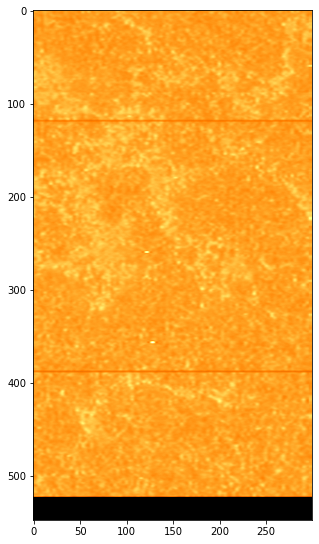

In [43]:
new_iris_data = iris_data[:,:,28]
new_iris_data = rebin.congrid(new_iris_data, [548, 300])
fig, ax = plt.subplots(1, 1, figsize=[5, 10])
ax.imshow(new_iris_data, cmap="afmhot")

In [18]:
aia_paths = [x for x in os.listdir(aia_folder)]
to_examine = [3,7,8]
to_examine = [aia_paths[i] for i in to_examine]

img_data_list = []
header_data_list = []
for aia in to_examine:
    hdul = fits.open(aia_folder + aia)
    img_data = hdul[0].data
    header_data_list.append(hdul[0].header)
    hdul.close()
    img_data_list.append(img_data)

390.28 -398.299
(568, 471, 608)


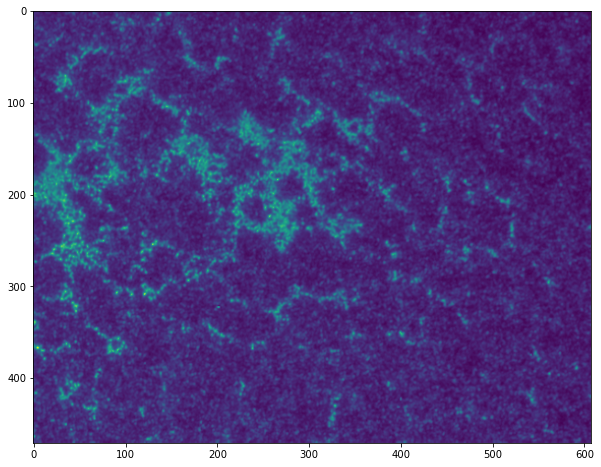

In [39]:
#1600
aia_data = img_data_list[0]

xcen, ycen = header_data_list[0]['XCEN'], header_data_list[0]['YCEN']
print(xcen, ycen)
dim_aia = img_data_list[0].shape
print(dim_aia)

aia1600 = img_data_list[0]

extent_aia = [low_x, high_x, low_y, high_y]
fig, ax = plt.subplots(figsize=[10,8])
ax.imshow(img_data_list[0][dim_aia[0]-1,:,:])#, cmap=cm.sdoaia1600)

rect = patches.Rectangle((extent_hx_hy[0], extent_hx_hy[3]), extent_hx_hy[1]-extent_hx_hy[0], extent_hx_hy[2]-extent_hx_hy[3], linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)

In [59]:
import pick_from_LMSAL
import my_fits

#obsid, numraster = '20211015_051453_3600009176', 0
obsid, numraster = '20220607_202829_3620106067', 0
iris_file = pick_from_LMSAL.obsid_raster(obsid, raster=numraster)
aia_file = pick_from_LMSAL.obsid_raster2aia(obsid, raster=numraster)
#aia_file = pick_from_LMSAL.obsid_raster2aia(obsid, raster=numraster, pattern='1600')

aia_data = my_fits.read(aia_file[0])
aia_1600 = aia_data[0]
hdr_aia_1600 = aia_data[1]
aia_middle_step = int(aia_1600.shape[0]//2)
aia_middle_step = ei.get_ori_val(xcen_aia, a.raster['Mg II k 2796'].XCEN)
aia_1600 = aia_1600[aia_middle_step,:,:]
info_1600 = my_fits.read(aia_file[0], ext=1)
xcen_aia= info_1600[0][:,10]
ycen_aia = info_1600[0][:,11]
hdr_iris_data = ei.only_header(iris_file[0])
aux_hdr_iris_data = ei.only_header(iris_file[0], extension=1)
xcen_iris = hdr_iris_data['XCEN']
ycen_iris = hdr_iris_data['YCEN']
xscl_iris = aux_hdr_iris_data['CDELT3']
yscl_iris = aux_hdr_iris_data['CDELT2']
xscl_aia = hdr_aia_1600['CDELT1']
yscl_aia = hdr_aia_1600['CDELT2']
#
print()
print('IRIS coordinates: [{},{}]'.format(xcen_iris, ycen_iris))
print('AIA coordinates (closest ima. #{}): [{},{}]'.format(aia_middle_step, xcen_aia[aia_middle_step], ycen_aia[aia_middle_step]))
print()

Looking for... /irisa/data/level2/2022/06/07/20220607_202829_3620106067/*20220607_202829_3620106067*raster*_r00000.fits
Looking for... /irisa/data/level2/2022/06/07/20220607_202829_3620106067/aia/aia*20220607_202829_3620106067**.fits


IndexError: list index out of range